# Overview

This notebook introduces a function to identify overlapping cells on different meshes on the same domain.

A key assumption (for the time being) is that individual cells are convex.

The algorithm will identify the cell center of a cell is inside a another larger cell. Thus, the algorithm will not be able to take in to account non-overlapping boundaries between differently resoluted grids.

# Conceptual model

This section describes conceptually how the algorithm will work. For the time being, we are considering 2D only.

Consider a domain $\Omega$. Denote different discretizations of $\Omega$ by $\omega_i$. A discretization is defined by non-overlapping volumes that in total covers the entire domain exactly.

Let $\omega_c$ be some relatively coarse grid and $\omega_f$ some refined grid of the same domain.

Our goal is to provide a mapping which identifies which cells (cell centers) in $\omega_f$ are contained in which cells in $\omega_c$.

To do this, we will loop through every cell in the coarse grid, formally construct the convex polygon of the cell, then find which cell (centers) in the fine grid are contained in the coarse grid cell. The information will be stored in a sparse matrix.

**NOTE: The algorithm is not stable when points are exactly on boundaries**

In [159]:
import porepy as pp
import numpy as np
import scipy.sparse as sps

from porepy.geometry.geometry_property_checks import is_ccw_polyline, is_ccw_polygon, point_in_polygon

In [158]:
def make_points_ccw(p, tol=1e-5):
    """
    Return the points sorted in ccw order.
    
    Sort points in 2D, by ccw order. Not tested for non-convex point sets.
    
    Parameters:
        p (np.ndarray, 2 x n): Points to be sorted.
    
    Returns:
        np.ndarray, ccw sorted list of points.
        
    Steps of algorithm:
    Let poly = p.copy()
    
    CASE I: 3 points provided.
    1. Check if points are collinear.
        - If True: Raise ValueError.
    2. Run is_ccw_polyline(poly) 
        - If True: Return poly
        - Otherwise: Return poly.copy()[:, ::-1]
        
    CASE II: 4 points provided.
    1. Name the points A,B,C,D.
    2. Consider two points, e.g. AB.
    3. Check if any of C and D is collinear to AB.
        a. If any:
            - Raise ValueError
    3. Check that C and D is ccw relative to AB
        a. If both cw: 
            - Continue with XY = BA.
        b. If one cw and one ccw:
            - Continue with XY = AC (or AD, it doesn't matter)
        c. If both ccw: 
            - Continue with XY = AB
    4. Name the other two points Z, W.
    5. Run is_ccw_polygon on XYZW and XYWZ.
        a. Return the case which is True.
        
    CASE III: Number of points provided > 4.
    1. Raise NotYetImplementedError.
    
    """
    
    num_p = p.shape[1]
    poly = p.copy()
    
    assert(num_p > 2) # Need to provide at least 3 points.
    
    # CASE I:
    if num_p == 3:
        A,B,C = poly.T
        if np.abs(np.cross(C-A,B-A)) < tol:
            raise ValueError("Points are collinear.")
        
        if is_ccw_polyline(A,B,C,tol=tol):
            return poly
        else:
            return poly.copy()[:, ::-1]
    
    # CASE II:
    elif num_p == 4:
        A,B,C,D = poly.T
        collC = np.abs(np.cross(C-A,B-A)) < tol
        collD = np.abs(np.cross(D-A,B-A)) < tol
        if collC or collD:
            raise ValueError("Some triples of points are collinear.")
        
        orientations = is_ccw_polyline(A,B,np.array((C,D)).T)
        if np.all(np.logical_not(orientations)):  # Both other pts are cw.
            A,B = B,A
        elif np.any(np.logical_not(orientations)): # Exactly one pt is cw.
            B,C=C,B
        
        # Either ABCD or ABDC is either cw or ccw.
        arr1 = np.array((A,B,C,D)).T
        arr2 = np.array((A,B,D,C)).T
        if is_ccw_polygon(arr1):
            return arr1
        elif is_ccw_polygon(arr1[:, ::-1]):
            return arr1[:, ::-1]
        elif is_ccw_polygon(arr2):
            return arr2
        elif is_ccw_polygon(arr2[:, ::-1]):
            return arr2[:, ::-1]
        else:
            raise Error("An unexpected error occured.")
        
    
    elif num_p > 4:
        raise NotImplemented("Not implemented for larger polygons.")

In [203]:
def identify_overlap(gc, gf):
    """
    Method to find overlapping cells in two grids over the same domain (2D).
    
    Parameters:
    gc (porepy.Grid): The coarse grid with Nc number of cells
    gf (porepy.Grid): The fine grid with Nf number of cells
    
    Returns:
    Nf x Nc sparse matrix: If entry (i,j)  contains 1, then cell i in the fine grid 
                           is contained in cell j in the coarse grid.
                            
    """
    
    # cell_nodes is a num_nodes x num_cells sparse column oriented matrix. (sps.csc_matrix).
    ccell_nodes = gc.cell_nodes()
    cnnz = ccell_nodes.nnz
    slices = zip(ccell_nodes.indptr[:-1], ccell_nodes.indptr[1:])
    
    # Create sps.csc_matrix mapping coarse cells to fine cell centers.
    indptr = [0]
    indices = []
    
    for st, nd in slices:  # Loop through every cell.
        nodes = ccell_nodes.indices[st:nd]
        node_coords = np.array(gc.nodes[:,nodes][0:2])
        poly = make_points_ccw(node_coords)
        inside = point_in_polygon(poly, gf.cell_centers)#, tol=1e-5, default=True)
        inside_id = np.array([i for i, x in enumerate(inside) if x])  # Location of the (fine) nodes inside the coarse cell.
        
        indptr.extend([indptr[-1]+len(inside_id)])  # Update index pointer
        indices.extend(inside_id)  # Update indices of fine cells for the current coarse cell.
    
    data = np.ones(len(indices))
    
    ccell_fcell = sps.csc_matrix((data, indices, indptr))
    return ccell_fcell
        

# Do some testing that the algorithm works

Note that if points are exactly on the boundary, the algorithm will fail.
Some solutions to this should be considered.

E.g. When the mapping is constructed, find the points with no map, then find any (the first) coarse grid where this cell may be put.

In [204]:
Nx=Ny=2
physdims=[1,1]
gc = pp.CartGrid([Nx,Ny], physdims=physdims)
gc.compute_geometry()

N2 = 3
gf = pp.CartGrid([N2,N2], physdims=physdims)
gf.compute_geometry()

In [205]:
m = identify_overlap(gc=gc,gf=gf)
m.toarray()

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 1., 1., 1.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

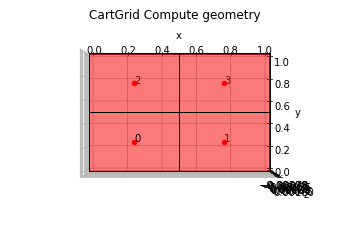

In [206]:
pp.plot_grid(gc, info='c', alpha=0.5)

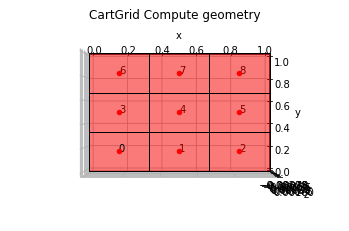

In [207]:
pp.plot_grid(gf, info='c', alpha=0.5)